# Imports

In [106]:
import pandas as pd
import utils
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from upos import upos
from scipy.stats import chi2_contingency, chi2, chisquare

# Constants + Helper Functions

In [107]:
CONJUNCTION_COLORS = {
    "and": "#be0aff",
    "or": "#580aff",
    "but": "#0043ce",
    "nor": "#d12c19"
}

CONJUNCTION_COLORS = {
    "and": "#9B5DE5",
    "or": "#00BBF9",
    "but": "#38b000",
    "nor": "#d90429",
}

LIKE_UNLIKE_COLORS = {
    "likes": "#008bf8",
    "unlikes": "#dc0073"
}

CATEGORY_COLORS = {
    "NP": "#ee1266",
    "VP": "#6a4c93",
    "ADJP": "#1982c4",
    "ADVP": "#0ead69",
    "PP": "#ff4b35",
    "SBAR": "#00cecb"
}

CONJUNCTIONS = ['and', 'or', 'but'] #, 'nor']

CATEGORIES = [upos.NOUN, upos.VERB, upos.ADJ, upos.ADV]

In [108]:
def get_df_from_path(path):
    '''
    Concatenate all CSV files in the specified path and return
    the result as a DataFrame.

    @param path (str): path to input CSV files
    @return (DataFrame): DataFrame containing all data
    '''
  
    all_files = glob.glob(path)

    # Concatenate all CSVs in the specified path into one dataframe
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    if li == []:
        return None

    df = pd.concat(li, axis=0, ignore_index=True)
    return df

In [109]:
def get_wordnet_dfs(df):
    '''
    Get five DataFrames for each WordNet relation (synonymy, antonymy,
    hypernymy, co-hyponymy, entailment) using examples from the given
    input df.

    @param df (DataFrame): input of raw coordination samples
    @return (5-tuple of DataFrames): tuple containing a DataFrame for each
        WordNet relation (synonymy_df, antonymy_df, hypernymy_df,
        cohyponymy_df, entailment_df)
    '''
    
    # Get like coordinations
    likes = utils.likes_df(df)

    # Filter out gaps
    likes = likes[(likes['1st Conjunct Lemma'] != "GAP") & (
        likes['2nd Conjunct Lemma'] != "GAP")]

    # Finding closures over wordnet relations produces redundant search warnings
    # We'll just filter these warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Get wordnet relations for like coordinations
        synonymy_df = utils.analyze_synonymy(likes)
        antonymy_df = utils.analyze_antonymy(likes)
        hypernymy_df = utils.analyze_hypernymy(likes)
        cohyponymy_df = utils.analyze_cohyponymy(likes)
        entailment_df = utils.analyze_entailment(likes)

    return (synonymy_df, antonymy_df, hypernymy_df, cohyponymy_df, entailment_df)

### Chi-square Test for Goodness of Fit

In [110]:
def chi2_goodness_of_fit(observed):
    print("Chi-square Test for Goodness of Fit\n")

    N = sum(observed)
    expected = [N / len(observed)] * len(observed)
    stat, p = chisquare(f_obs=observed, f_exp=expected)

    prob = 0.95
    alpha = 1.0 - prob

    print('Observed:', observed)
    print('Expected:', expected)
    print('N={}'.format(N))
    print('Degrees of Freedom = %d' % (len(observed) - 1))

    # interpret p-value
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

    print()

### Chi-square Test of Association
Adapted from https://machinelearningmastery.com/chi-squared-test-for-machine-learning/

In [111]:
def chi2_association_test(table):
    print("Chi-square Test of Association\n")

    N = sum([sum(l) for l in table])
    stat, p, dof, expected = chi2_contingency(table)
    
    print('Observed:', table)
    print('Expected:', expected)
    print('N={}'.format(N))
    print('Degrees of Freedom = %d' % dof)

    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' %
          (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

    print()


def chi2_by_conjunction(relation_df, freq_func, conjunctions=CONJUNCTIONS):

    group1_freqs = []
    group2_freqs = []

    for conjunction in conjunctions:

        df = relation_df.copy()
        df = df.loc[df['Conjunction'] == conjunction]

        if df is None:
            continue

        group1_freq, group2_freq = freq_func(df, raw=True)
        group1_freqs.append(group1_freq)
        group2_freqs.append(group2_freq)

    chi2_association_test([group1_freqs, group2_freqs])


def chi2_by_category(relation_df, freq_func, categories=CATEGORIES):

    group1_freqs = []
    group2_freqs = []

    for category in categories:

        df = relation_df.copy()
        df = df.loc[(df['1st Conjunct Category'] == category) &
                    (df['2nd Conjunct Category'] == category)]

        if df is None:
            continue

        group1_freq, group2_freq = freq_func(df, raw=True)
        group1_freqs.append(group1_freq)
        group2_freqs.append(group2_freq)

    chi2_association_test([group1_freqs, group2_freqs])

### Plotting Distributions on Single-Bar Charts

In [112]:
def plot_single_bar(labels, freqs, title, outfile, colors, ylabel='Percentage (%)'):

    x = np.arange(len(labels))  # the label locations
    width = 0.6  # the width of the bars
    freqs = [f * 100 for f in freqs]

    _, ax = plt.subplots()
    rects1 = ax.bar(x, freqs, width, color=colors)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{:.1f}'.format(height) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -12),
                    textcoords="offset points",
                    ha='center', va='bottom', color='white')

    plt.savefig(outfile, bbox_inches='tight')

In [113]:
def distribution_by_conjunction(relation_df, freq_func, relation_title, outfile,
    conjunctions=CONJUNCTIONS, source=None):

    labels = []
    freqs = []

    for conjunction in conjunctions:

        labels.append(conjunction)

        df = relation_df.copy()
        df = df.loc[df['Conjunction'] == conjunction]

        if df is None:
            continue

        freqs.append(freq_func(df))

    title = 'Percentages of Coordinations with {}\nby Conjunction'.format(
        relation_title)
    if source is not None:
        title = title + ' ({})'.format(source)

    plot_single_bar(labels, freqs, title, outfile, CONJUNCTION_COLORS.values())

In [114]:
def distribution_by_category(relation_df, freq_func, relation_title, outfile,
    categories=CATEGORIES, source=None):

    labels = []
    freqs = []

    nouns, verbs, adjps, advps = utils.likes_by_category(relation_df)

    if upos.NOUN in categories:
        labels.append('Nominal')
        freqs.append(freq_func(nouns))

    if upos.VERB in categories:
        labels.append('Verbal')
        freqs.append(freq_func(verbs))

    if upos.ADJ in categories:
        labels.append('Adjectival')
        freqs.append(freq_func(adjps))

    if upos.ADV in categories:
        labels.append('Adverbial')
        freqs.append(freq_func(advps))

    title = 'Percentages of Coordinations with {}\nby Syntactic Category'.format(
        relation_title)
    if source is not None:
        title = title + ' ({})'.format(source)

    plot_single_bar(labels, freqs, title, outfile, CATEGORY_COLORS.values())

### Plotting Distributions for Double-Bar Charts

In [115]:
def plot_double_bar(labels, sublabels, freqs1, freqs2, title, outfile):

    x = np.arange(len(labels))  # the label locations
    width = 0.45  # the width of the bars
    freqs1 = [f * 100 for f in freqs1]
    freqs2 = [f * 100 for f in freqs2]

    _, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, freqs1, width,
                    label=sublabels[0])
    rects2 = ax.bar(x + width/2, freqs2, width,
                    label=sublabels[1])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage (%)')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='center left', bbox_to_anchor=(0, 0.1))

    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{:.1f}'.format(height) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -12),
                    textcoords="offset points",
                    ha='center', va='bottom', color='white')

    for rect in rects2:
        height = rect.get_height()
        ax.annotate('{:.1f}'.format(height) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -12),
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.savefig(outfile, bbox_inches='tight')

In [116]:
def double_distribution_by_conjunction(relation_df, freq_func, relation_title,
    sublabels, outfile, conjunctions=CONJUNCTIONS, source=None):

    labels = []
    freqs1 = []
    freqs2 = []

    for conjunction in conjunctions:

        labels.append(conjunction)

        df = relation_df.copy()
        df = df.loc[df['Conjunction'] == conjunction]

        if df is None:
            continue

        freq1, freq2 = freq_func(df)
        freqs1.append(freq1)
        freqs2.append(freq2)

    title = 'Percentages of Coordinations with {}\nby Conjunction'.format(
        relation_title)
    if source is not None:
        title = title + ' ({})'.format(source)

    plot_double_bar(labels, sublabels, freqs1, freqs2, title, outfile)

In [117]:
def double_distribution_by_category(relation_df, freq_func, relation_title,
    sublabels, outfile, categories=CATEGORIES, source=None):

    labels = []
    freqs1 = []
    freqs2 = []

    nouns, verbs, adjps, advps = utils.likes_by_category(relation_df)

    if upos.NOUN in categories:
        labels.append('Nominal')
        freq1, freq2 = freq_func(nouns)
        freqs1.append(freq1)
        freqs2.append(freq2)

    if upos.VERB in categories:
        labels.append('Verbal')
        freq1, freq2 = freq_func(verbs)
        freqs1.append(freq1)
        freqs2.append(freq2)

    if upos.ADJ in categories:
        labels.append('Adjectival')
        freq1, freq2 = freq_func(adjps)
        freqs1.append(freq1)
        freqs2.append(freq2)

    if upos.ADV in categories:
        labels.append('Adverbial')
        freq1, freq2 = freq_func(advps)
        freqs1.append(freq1)
        freqs2.append(freq2)

    title = 'Percentages of Coordinations with {}\nby Category'.format(
        relation_title)
    if source is not None:
        title = title + ' ({})'.format(source)

    plot_double_bar(labels, sublabels, freqs1, freqs2, title, outfile)

# Load Data and Get WordNet Relations

In [118]:
# GUM
gum_samples = get_df_from_path('csv/GUM/*.csv')
gum_synonymy_df, gum_antonymy_df, gum_hypernymy_df, gum_cohyponymy_df, gum_entailment_df \
    = get_wordnet_dfs(gum_samples)

# EWT
ewt_samples = get_df_from_path('csv/EWT/*.csv')
ewt_synonymy_df, ewt_antonymy_df, ewt_hypernymy_df, ewt_cohyponymy_df, ewt_entailment_df \
    = get_wordnet_dfs(ewt_samples)

# PUD
pud_samples = get_df_from_path('csv/PUD/*.csv')
pud_synonymy_df, pud_antonymy_df, pud_hypernymy_df, pud_cohyponymy_df, pud_entailment_df \
    = get_wordnet_dfs(pud_samples)

# All sources
all_samples = utils.likes_df(pd.concat([gum_samples, ewt_samples, pud_samples]))
all_synonymy_df = pd.concat(
    [gum_synonymy_df, ewt_synonymy_df, pud_synonymy_df], axis=0, ignore_index=True)
all_antonymy_df = pd.concat(
    [gum_antonymy_df, ewt_antonymy_df, pud_antonymy_df], axis=0, ignore_index=True)
all_hypernymy_df = pd.concat(
    [gum_hypernymy_df, ewt_hypernymy_df, pud_hypernymy_df], axis=0, ignore_index=True)
all_cohyponymy_df = pd.concat(
    [gum_cohyponymy_df, ewt_cohyponymy_df, pud_cohyponymy_df], axis=0, ignore_index=True)
all_entailment_df = pd.concat(
    [gum_entailment_df, ewt_entailment_df, pud_entailment_df], axis=0, ignore_index=True)

utils.pretty_print(all_synonymy_df[all_synonymy_df['Synonyms?']], 'rtf/synonyms.rtf')
utils.pretty_print(all_antonymy_df[all_antonymy_df['Antonyms?']], 'rtf/antonyms.rtf')
utils.pretty_print(all_hypernymy_df[all_hypernymy_df['1st Conjunct Hypernym?']], 'rtf/1st_hypernyms.rtf')
utils.pretty_print(all_hypernymy_df[all_hypernymy_df['2nd Conjunct Hypernym?']], 'rtf/2nd_hypernyms.rtf')
utils.pretty_print(all_cohyponymy_df[all_cohyponymy_df['Co-hyponyms?']], 'rtf/co-hyponyms.rtf')
utils.pretty_print(all_entailment_df[all_entailment_df['1st Conjunct Entails 2nd?']], 'rtf/1st_entailments.rtf')
utils.pretty_print(all_entailment_df[all_entailment_df['2nd Conjunct Entails 1st?']], 'rtf/2nd_entailments.rtf')

# Overall Statistics

In [119]:
print('Total like coordination count:', len(all_samples))

all_samples['In WordNet?'] = all_samples.apply(lambda row:
    utils.in_wordnet(row['1st Conjunct Lemma'], row['1st Conjunct Category']) and
    utils.in_wordnet(row['2nd Conjunct Lemma'], row['1st Conjunct Category']),
    axis=1)

print('Like coordinations with conjuncts present in WordNet:', len(all_samples[all_samples['In WordNet?']]))

Total like coordination count: 6889
Like coordinations with conjuncts present in WordNet: 6361


Chi-square Test for Goodness of Fit

Observed: [5572, 720, 579, 18]
Expected: [1722.25, 1722.25, 1722.25, 1722.25]
N=6889
Degrees of Freedom = 3
stat=11633.949, p=0.000
Dependent (reject H0)



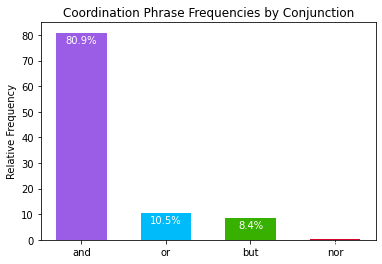

In [120]:
and_count = len(all_samples[all_samples['Conjunction'] == 'and'])
or_count = len(all_samples[all_samples['Conjunction'] == 'or'])
but_count = len(all_samples[all_samples['Conjunction'] == 'but'])
nor_count = len(all_samples[all_samples['Conjunction'] == 'nor'])

conj_counts = [and_count, or_count, but_count, nor_count]
conj_dist = [count / sum(conj_counts) for count in conj_counts]
chi2_goodness_of_fit(conj_counts)
plot_single_bar(['and', 'or', 'but', 'nor'], conj_dist,
'Coordination Phrase Frequencies by Conjunction', 'charts/conjunction_frequencies.pdf',
CONJUNCTION_COLORS.values(), 'Relative Frequency')

In [121]:
first_conjunct_gaps = all_samples[(all_samples['1st Conjunct Lemma'] == "GAP")]
second_conjunct_gaps = all_samples[(all_samples['2nd Conjunct Lemma'] == "GAP")]

print("First conjunct elided:", len(first_conjunct_gaps))
print("Second conjunct elided:", len(second_conjunct_gaps))
first_conjunct_gaps

First conjunct elided: 2
Second conjunct elided: 25


,1st Conjunct Category,1st Conjunct Lemma,1st Conjunct Text,2nd Conjunct Category,2nd Conjunct Lemma,2nd Conjunct Text,Conjunction,Sentence Text,Cosine Similarity,In WordNet?
3848,VERB,GAP,deny,VERB,deny,denied,and,The evidence of President Trump's abuse of pow...,-0.008484,True
4646,VERB,GAP,taken,VERB,take,taken,and,Various mitigating actions have been and will ...,-0.049169,True


# Synonymy

In [122]:
def get_synonyms_freqs(df, raw=False):
    # Get synonyms
    syns = df.loc[(df['Synonyms?'] == True)]

    # Get counts
    syns_count = len(syns)
    tot = len(df)

    if raw:
        return (syns_count, tot - syns_count)
        
    return syns_count / tot if tot != 0 else 0

### By Conjunction

Chi-square Test of Association

Observed: [[153, 23, 17], [5213, 655, 553]]
Expected: [[ 156.58270336   19.78439673   16.63289991]
 [5209.41729664  658.21560327  553.36710009]]
N=6614
Degrees of Freedom = 2
probability=0.950, critical=5.991, stat=0.631
Independent (fail to reject H0)
significance=0.050, p=0.729
Independent (fail to reject H0)



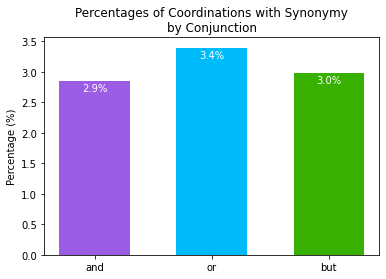

In [123]:
def synonym_conjunction_distribution(df, outfile, source=None):
    distribution_by_conjunction(df, get_synonyms_freqs, "Synonymy", outfile, source=source)

chi2_by_conjunction(all_synonymy_df, get_synonyms_freqs)
synonym_conjunction_distribution(all_synonymy_df, 'charts/synonymy_by_conjunction.pdf')
# synonym_conjunction_distribution(gum_synonymy_df, 'charts/GUM_synonymy_by_conjunction.pdf', source='GUM')
# synonym_conjunction_distribution(ewt_synonymy_df, 'charts/EWT_synonymy_by_conjunction.pdf', source='EWT')
# synonym_conjunction_distribution(pud_synonymy_df, 'charts/PUD_synonymy_by_conjunction.pdf', source='PUD')

### By Category

Chi-square Test of Association

Observed: [[38, 140, 14, 2], [2410, 3301, 622, 104]]
Expected: [[7.16199668e+01 1.00671694e+02 1.86071482e+01 3.10119137e+00]
 [2.37638003e+03 3.34032831e+03 6.17392852e+02 1.02898809e+02]]
N=6631
Degrees of Freedom = 3
probability=0.950, critical=7.815, stat=33.663
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)



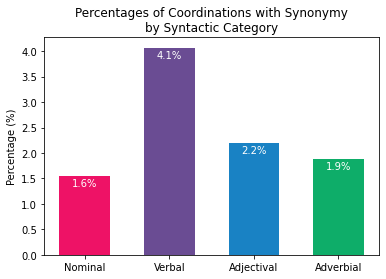

In [124]:
def synonym_category_distribution(df, outfile, source=None):
    distribution_by_category(df, get_synonyms_freqs, "Synonymy", outfile, source=source)

chi2_by_category(all_synonymy_df, get_synonyms_freqs)
synonym_category_distribution(all_synonymy_df, 'charts/synonymy_by_category.pdf')
# synonym_category_distribution(gum_synonymy_df, 'charts/GUM_synonymy_by_category.pdf', source='GUM')
# synonym_category_distribution(ewt_synonymy_df, 'charts/EWT_synonymy_by_category.pdf', source='EWT')
# synonym_category_distribution(pud_synonymy_df, 'charts/PUD_synonymy_by_category.pdf', source='PUD')

# Antonymy

In [125]:
def get_antonyms_freqs(df, raw=False):
    # Get antonyms
    ants = df.loc[(df['Antonyms?'] == True)]
    ants.reset_index(drop=True, inplace=True)

    # Get counts
    count_ants = len(ants.index)
    tot = len(df.index)

    if raw:
        return (count_ants, tot - count_ants)
    return count_ants / tot if tot != 0 else 0


### By Conjunction

Chi-square Test of Association

Observed: [[38, 13, 1], [563, 51, 52]]
Expected: [[ 43.5264624    4.63509749   3.83844011]
 [557.4735376   59.36490251  49.16155989]]
N=718
Degrees of Freedom = 2
probability=0.950, critical=5.991, stat=19.294
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)



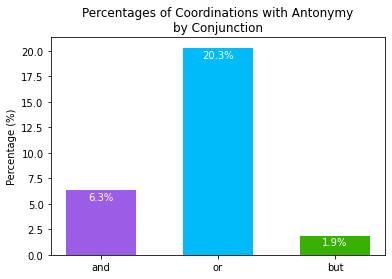

In [126]:
def antonym_conjunction_distribution(df, outfile, source=None):
    distribution_by_conjunction(df, get_antonyms_freqs, "Antonymy", outfile, source=source)

chi2_by_conjunction(all_antonymy_df, get_antonyms_freqs)
antonym_conjunction_distribution(all_antonymy_df, 'charts/antonymy_by_conjunction.pdf')
# antonym_conjunction_distribution(gum_antonymy_df, 'charts/GUM_antonymy_by_conjunction.pdf', source='GUM')
# antonym_conjunction_distribution(ewt_antonymy_df, 'charts/EWT_antonymy_by_conjunction.pdf', source='EWT')
# antonym_conjunction_distribution(pud_antonymy_df, 'charts/PUD_antonymy_by_conjunction.pdf', source='PUD')

### By Category

Chi-square Test of Association

Observed: [[37, 15], [580, 87]]
Expected: [[ 44.62308762   7.37691238]
 [572.37691238  94.62308762]]
N=719
Degrees of Freedom = 1
probability=0.950, critical=3.841, stat=8.640
Dependent (reject H0)
significance=0.050, p=0.003
Dependent (reject H0)



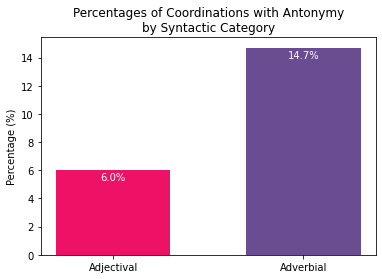

In [127]:
def antonym_category_distribution(df, outfile, source=None):
    distribution_by_category(df, get_antonyms_freqs, "Antonymy",
        outfile, categories=[upos.ADJ, upos.ADV], source=source)

chi2_by_category(all_antonymy_df, get_antonyms_freqs, categories=[upos.ADJ, upos.ADV])
antonym_category_distribution(all_antonymy_df, 'charts/antonymy_by_category.pdf')
# antonym_category_distribution(gum_antonymy_df, 'charts/GUM_antonymy_by_category.pdf', source='GUM')
# antonym_category_distribution(ewt_antonymy_df, 'charts/EWT_antonymy_by_category.pdf', source='EWT')
# antonym_category_distribution(pud_antonymy_df, 'charts/PUD_antonymy_by_category.pdf', source='PUD')

# Hypernymy

In [128]:
def get_hypernymy_freqs(df, raw=False):
    tot = len(df.index)
    df = df.loc[(df['1st Conjunct Hypernym?'] == True) | (df['2nd Conjunct Hypernym?'] == True)]
    df = df.loc[(df['1st Conjunct Hypernym?']) != (df['2nd Conjunct Hypernym?'])]

    # Get 1st conjunct hypernymy
    hyps1 = df.loc[(df['1st Conjunct Hypernym?'] == True)]
    hyps1.reset_index(drop=True, inplace=True)

    # Get 2nd conjunct hypernymy
    hyps2 = df.loc[(df['2nd Conjunct Hypernym?'] == True)]
    hyps2.reset_index(drop=True, inplace=True)

    # Get counts
    count_hyps1 = len(hyps1.index)
    count_hyps2 = len(hyps2.index)
    
    if raw:
        return (count_hyps1, count_hyps2)

    return (count_hyps1 / tot, count_hyps2 / tot) if tot != 0 else (0,0)

In [129]:
hypernymy_freqs = list(get_hypernymy_freqs(all_hypernymy_df, raw=True))
chi2_goodness_of_fit(hypernymy_freqs)

Chi-square Test for Goodness of Fit

Observed: [318, 353]
Expected: [335.5, 335.5]
N=671
Degrees of Freedom = 1
stat=1.826, p=0.177
Independent (fail to reject H0)



### By Conjunction

'and'
Chi-square Test for Goodness of Fit

Observed: [250, 278]
Expected: [264.0, 264.0]
N=528
Degrees of Freedom = 1
stat=1.485, p=0.223
Independent (fail to reject H0)


'or'
Chi-square Test for Goodness of Fit

Observed: [33, 47]
Expected: [40.0, 40.0]
N=80
Degrees of Freedom = 1
stat=2.450, p=0.118
Independent (fail to reject H0)


'but'
Chi-square Test for Goodness of Fit

Observed: [35, 27]
Expected: [31.0, 31.0]
N=62
Degrees of Freedom = 1
stat=1.032, p=0.310
Independent (fail to reject H0)


Chi-square Test of Association

Observed: [[250, 33, 35], [278, 47, 27]]
Expected: [[250.60298507  37.97014925  29.42686567]
 [277.39701493  42.02985075  32.57313433]]
N=670
Degrees of Freedom = 2
probability=0.950, critical=5.991, stat=3.250
Independent (fail to reject H0)
significance=0.050, p=0.197
Independent (fail to reject H0)



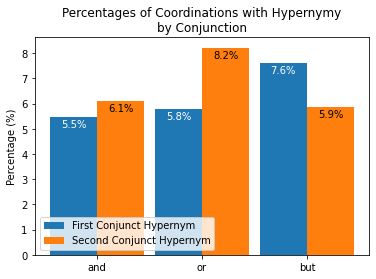

In [130]:
def hypernymy_conjunction_distribution(df, outfile, source=None):
    double_distribution_by_conjunction(df, get_hypernymy_freqs, "Hypernymy",
    ('First Conjunct Hypernym', 'Second Conjunct Hypernym'), outfile, source=source)

print("'and'")
hypernymy_freqs = list(get_hypernymy_freqs(all_hypernymy_df[all_hypernymy_df['Conjunction'] == 'and'], raw=True))
chi2_goodness_of_fit(hypernymy_freqs)
print()

print("'or'")
hypernymy_freqs = list(get_hypernymy_freqs(all_hypernymy_df[all_hypernymy_df['Conjunction'] == 'or'], raw=True))
chi2_goodness_of_fit(hypernymy_freqs)
print()

print("'but'")
hypernymy_freqs = list(get_hypernymy_freqs(all_hypernymy_df[all_hypernymy_df['Conjunction'] == 'but'], raw=True))
chi2_goodness_of_fit(hypernymy_freqs)
print()

chi2_by_conjunction(all_hypernymy_df, get_hypernymy_freqs)
hypernymy_conjunction_distribution(all_hypernymy_df, 'charts/hypernymy_by_conjunction.pdf')
# hypernymy_conjunction_distribution(gum_hypernymy_df, 'charts/GUM_hypernymy_by_conjunction.pdf', source='GUM')
# hypernymy_conjunction_distribution(ewt_hypernymy_df, 'charts/EWT_hypernymy_by_conjunction.pdf', source='EWT')
# hypernymy_conjunction_distribution(pud_hypernymy_df, 'charts/PUD_hypernymy_by_conjunction.pdf', source='PUD')

### By Category

Nouns
Chi-square Test for Goodness of Fit

Observed: [108, 114]
Expected: [111.0, 111.0]
N=222
Degrees of Freedom = 1
stat=0.162, p=0.687
Independent (fail to reject H0)


Verbs
Chi-square Test for Goodness of Fit

Observed: [210, 239]
Expected: [224.5, 224.5]
N=449
Degrees of Freedom = 1
stat=1.873, p=0.171
Independent (fail to reject H0)


Chi-square Test of Association

Observed: [[108, 210], [114, 239]]
Expected: [[105.21013413 212.78986587]
 [116.78986587 236.21013413]]
N=671
Degrees of Freedom = 1
probability=0.950, critical=3.841, stat=0.142
Independent (fail to reject H0)
significance=0.050, p=0.707
Independent (fail to reject H0)



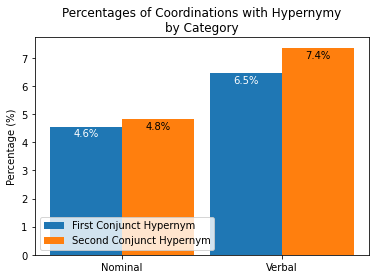

In [131]:
def hypernymy_category_distribution(df, outfile, source=None):
    double_distribution_by_category(df, get_hypernymy_freqs, "Hypernymy",
        ('First Conjunct Hypernym', 'Second Conjunct Hypernym'), outfile,
        categories=[upos.NOUN, upos.VERB], source=source)

nouns, verbs, _, _ = utils.likes_by_category(all_hypernymy_df)

print("Nouns")
hypernymy_freqs = list(get_hypernymy_freqs(nouns, raw=True))
chi2_goodness_of_fit(hypernymy_freqs)
print()

print("Verbs")
hypernymy_freqs = list(get_hypernymy_freqs(verbs, raw=True))
chi2_goodness_of_fit(hypernymy_freqs)
print()

chi2_by_category(all_hypernymy_df, get_hypernymy_freqs, categories=[upos.NOUN, upos.VERB])
hypernymy_category_distribution(all_hypernymy_df, 'charts/hypernymy_by_category.pdf')
# hypernymy_category_distribution(gum_hypernymy_df, 'charts/GUM_hypernymy_by_category.pdf', source='GUM')
# hypernymy_category_distribution(ewt_hypernymy_df, 'charts/EWT_hypernymy_by_category.pdf', source='EWT')
# hypernymy_category_distribution(pud_hypernymy_df, 'charts/PUD_hypernymy_by_category.pdf', source='PUD')

# Co-Hyponymy

In [132]:
def get_cohyponyms_freqs(df, raw=False):
    # Get co-hyponymy
    hyps = df.loc[(df['Co-hyponyms?'] == True)]
    hyps.reset_index(drop=True, inplace=True)

    # Get counts
    count_hyps = len(hyps.index)
    tot = len(df.index)

    if raw:
        return (count_hyps, tot - count_hyps)
        
    return count_hyps / tot if tot != 0 else 0

### By Conjunction

Chi-square Test of Association

Observed: [[802, 99, 84], [3947, 509, 432]]
Expected: [[ 796.48646348  101.97173506   86.54180146]
 [3952.51353652  506.02826494  429.45819854]]
N=5873
Degrees of Freedom = 2
probability=0.950, critical=5.991, stat=0.240
Independent (fail to reject H0)
significance=0.050, p=0.887
Independent (fail to reject H0)



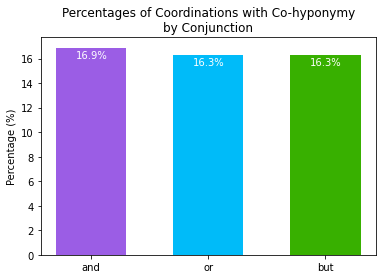

In [133]:
def cohyponymy_conjunction_distribution(df, outfile, source=None):
    distribution_by_conjunction(df, get_cohyponyms_freqs, "Co-hyponymy", outfile, source=source)

chi2_by_conjunction(all_cohyponymy_df, get_cohyponyms_freqs)
cohyponymy_conjunction_distribution(all_cohyponymy_df, 'charts/cohyponymy_by_conjunction.pdf')
# cohyponymy_conjunction_distribution(gum_cohyponymy_df, 'charts/GUM_cohyponymy_by_conjunction.pdf', source='GUM')
# cohyponymy_conjunction_distribution(ewt_cohyponymy_df, 'charts/EWT_cohyponymy_by_conjunction.pdf', source='EWT')
# cohyponymy_conjunction_distribution(pud_cohyponymy_df, 'charts/PUD_cohyponymy_by_conjunction.pdf', source='PUD')

### By Category

Chi-square Test of Association

Observed: [[280, 706], [2168, 2735]]
Expected: [[ 409.87060621  576.12939379]
 [2038.12939379 2864.87060621]]
N=5889
Degrees of Freedom = 1
probability=0.950, critical=3.841, stat=83.938
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)



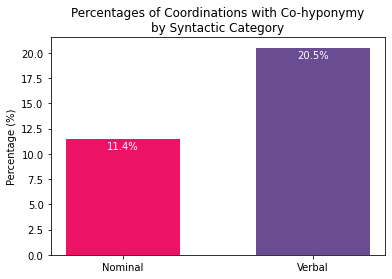

In [134]:
def cohyponymy_category_distribution(df, outfile, source=None):
    distribution_by_category(df, get_cohyponyms_freqs, "Co-hyponymy", outfile,
        categories=[upos.NOUN, upos.VERB], source=source)

chi2_by_category(all_cohyponymy_df, get_cohyponyms_freqs, categories=[upos.NOUN, upos.VERB])
cohyponymy_category_distribution(all_cohyponymy_df, 'charts/cohyponymy_by_category.pdf')
# cohyponymy_category_distribution(gum_cohyponymy_df, 'charts/GUM_cohyponymy_by_category.pdf', source='GUM')
# cohyponymy_category_distribution(ewt_cohyponymy_df, 'charts/EWT_cohyponymy_by_category.pdf', source='EWT')
# cohyponymy_category_distribution(pud_cohyponymy_df, 'charts/PUD_cohyponymy_by_category.pdf', source='PUD')

# Entailment

In [135]:
def get_entailment_freqs(df, raw=False):
    tot = len(df.index)
    
    df = df.loc[(df['1st Conjunct Entails 2nd?'] == True) | (df['2nd Conjunct Entails 1st?'] == True)]
    df = df.loc[(df['1st Conjunct Entails 2nd?']) != (df['2nd Conjunct Entails 1st?'])]

    # Get 1st conjunct entailment
    entl1 = df.loc[(df['1st Conjunct Entails 2nd?'] == True)]
    entl1.reset_index(drop=True, inplace=True)

    # Get 2nd conjunct entailment
    entl2 = df.loc[(df['2nd Conjunct Entails 1st?'] == True)]
    entl2.reset_index(drop=True, inplace=True)

    # Get counts
    count_entl1 = len(entl1.index)
    count_entl2 = len(entl2.index)
    
    if raw:
        return (count_entl1, count_entl2)

    return (count_entl1 / tot, count_entl2 / tot) if tot != 0 else (0,0)

In [136]:
entailment_freqs = list(get_entailment_freqs(all_entailment_df, raw=True))
chi2_goodness_of_fit(entailment_freqs)

Chi-square Test for Goodness of Fit

Observed: [10, 16]
Expected: [13.0, 13.0]
N=26
Degrees of Freedom = 1
stat=1.385, p=0.239
Independent (fail to reject H0)



# By Conjunction

'and'
Chi-square Test for Goodness of Fit

Observed: [7, 14]
Expected: [10.5, 10.5]
N=21
Degrees of Freedom = 1
stat=2.333, p=0.127
Independent (fail to reject H0)


'or'
Chi-square Test for Goodness of Fit

Observed: [0, 1]
Expected: [0.5, 0.5]
N=1
Degrees of Freedom = 1
stat=1.000, p=0.317
Independent (fail to reject H0)


'but'
Chi-square Test for Goodness of Fit

Observed: [3, 1]
Expected: [2.0, 2.0]
N=4
Degrees of Freedom = 1
stat=1.000, p=0.317
Independent (fail to reject H0)


Chi-square Test of Association

Observed: [[7, 0, 3], [14, 1, 1]]
Expected: [[ 8.07692308  0.38461538  1.53846154]
 [12.92307692  0.61538462  2.46153846]]
N=26
Degrees of Freedom = 2
probability=0.950, critical=5.991, stat=3.115
Independent (fail to reject H0)
significance=0.050, p=0.211
Independent (fail to reject H0)



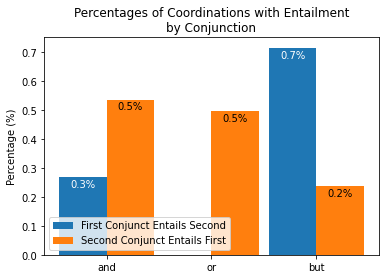

In [137]:
def entailment_conjunction_distribution(df, outfile, source=None):
    double_distribution_by_conjunction(df, get_entailment_freqs, "Entailment",
        ('First Conjunct Entails Second', 'Second Conjunct Entails First'), outfile,
        source=source)

print("'and'")
entailment_freqs = list(get_entailment_freqs(all_entailment_df[all_entailment_df['Conjunction'] == 'and'], raw=True))
chi2_goodness_of_fit(entailment_freqs)
print()

print("'or'")
entailment_freqs = list(get_entailment_freqs(all_entailment_df[all_entailment_df['Conjunction'] == 'or'], raw=True))
chi2_goodness_of_fit(entailment_freqs)
print()

print("'but'")
entailment_freqs = list(get_entailment_freqs(all_entailment_df[all_entailment_df['Conjunction'] == 'but'], raw=True))
chi2_goodness_of_fit(entailment_freqs)
print()

chi2_by_conjunction(all_entailment_df, get_entailment_freqs)
entailment_conjunction_distribution(all_entailment_df, 'charts/entailment_by_conjunction.pdf')
# entailment_conjunction_distribution(gum_entailment_df, 'charts/GUM_entailment_by_conjunction.pdf', source='GUM')
# entailment_conjunction_distribution(ewt_entailment_df, 'charts/EWT_entailment_by_conjunction.pdf', source='EWT')
# entailment_conjunction_distribution(pud_entailment_df, 'charts/PUD_entailment_by_conjunction.pdf', source='PUD')

# Word2Vec Cosine Similarity

and
mean: 0.3164768924270819
std: 0.2503077467759119
count: 5572
or
mean: 0.38265919765190237
std: 0.29406816316229656
count: 720
but
mean: 0.3725762513307173
std: 0.3093167743405943
count: 579


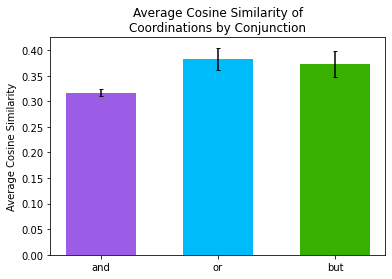

In [138]:
labels = []
freqs = []
vars = []

for conjunction in CONJUNCTIONS:
    print(conjunction)
    
    labels.append(conjunction)
    
    df = all_samples.copy()
    df = df.loc[df['Conjunction'] == conjunction]

    print('mean:', str(df['Cosine Similarity'].mean()))
    print('std:', str(df['Cosine Similarity'].std()))
    print('count:', str(len(df)))
 
    freqs.append(df['Cosine Similarity'].mean())
    vars.append(df['Cosine Similarity'].sem())

sems = []
for v in vars:
    sems.append(v * 2)

x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots()
ax.bar(x, freqs, width, label='Likes', capsize=2, color=CONJUNCTION_COLORS.values(), yerr=sems)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Cosine Similarity')
ax.set_title('Average Cosine Similarity of\nCoordinations by Conjunction')
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.savefig('charts/cossim_conjunction.pdf', bbox_inches='tight')

NOUN
mean: 0.2664754350977927
std: 0.17920010884178814
count: 2397
VERB
mean: 0.24087349116285062
std: 0.13144272970758453
count: 3149
ADJ
mean: 0.3080903868180309
std: 0.16465732765456648
count: 626
ADV
mean: 0.43899929111725405
std: 0.22046156887020033
count: 96


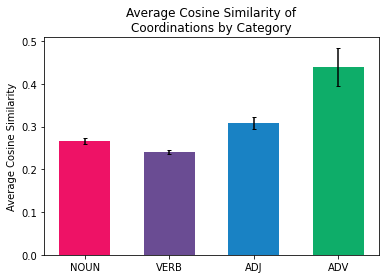

In [139]:
labels = []
freqs = []
vars = []

for category in CATEGORIES:
    print(category)
    
    labels.append(category)
    
    df = all_samples.copy()
    df = df[df['1st Conjunct Lemma'] != df['2nd Conjunct Lemma']]
    df = df.loc[df['1st Conjunct Category'] == category]
    df = df.loc[df['2nd Conjunct Category'] == category]

    print('mean:', str(df['Cosine Similarity'].mean()))
    print('std:', str(df['Cosine Similarity'].std()))
    print('count:', str(len(df)))
 
    freqs.append(df['Cosine Similarity'].mean())
    vars.append(df['Cosine Similarity'].sem())

sems = []
for v in vars:
    sems.append(2 * v)

x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots()
ax.bar(x, freqs, width, label='Likes', capsize=2, color=CATEGORY_COLORS.values(), yerr=sems)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Cosine Similarity')
ax.set_title('Average Cosine Similarity of\nCoordinations by Category')
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.savefig('charts/cossim_category.pdf', bbox_inches='tight')